In [278]:
import pandas as pd
import re
import torch
import torch.nn as nn
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## 1. Read Dataset

In [ ]:
text = pd.read_csv("IMDB Dataset.csv")
print(len(text)) # check  how many reviews in total

50000


## 2. Preprocess

In [280]:
def preprocess_text(text):
    text = BeautifulSoup(text, "html.parser").get_text() # Clean the HTML tags from the dataset, e.g. <br>
    
    text = re.sub(r'\d', '#', text)  # Replace all digits with #
    text = re.sub(r'\r\n', ' ', text)  # Replace newline characters with spaces
    text = re.sub(r' +', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^a-zA-Z\s\.\%\#\']', '', text)  # Remove special characters except periods, %, and '
    text = text.strip()  # Remove leading and trailing spaces
    text = text.lower()  # Convert to lowercase
    return text

In [ ]:
# Clean text
text['review'] = text['review'].apply(preprocess_text)
# Convert sentiment labels
text['sentiment'] = text['sentiment'].map({'positive': 1, 'negative': 0})
# print sample cleaned reviews
print(text.head(10))

/var/folders/hc/9l8qbn_15_7147jg07lzs7vm0000gn/T/ipykernel_57099/3119421847.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text() # Clean the HTML tags from the dataset, e.g. <br>


                                              review  sentiment
0  one of the other reviewers has mentioned that ...          1
1  a wonderful little production. the filming tec...          1
2  i thought this was a wonderful way to spend ti...          1
3  basically there's a family where a little boy ...          0
4  petter mattei's love in the time of money is a...          1
5  probably my alltime favorite movie a story of ...          1
6  i sure would like to see a resurrection of a u...          1
7  this show was an amazing fresh  innovative ide...          0
8  encouraged by the positive comments about this...          0
9  if you like original gut wrenching laughter yo...          1


## 3. Tokenization

In [ ]:
# tokenizing and get vocabulary size
all_tokens = [word for review in text['review'] for word in word_tokenize(review)]
vocab = sorted(set(all_tokens)) # extracing all unique vocabualries using set and sorting them.
ctoi = {c: i for i, c in enumerate(vocab)}  # project token c to index i map.

vocab_size = len(ctoi)
print(vocab_size) # check the vocabulary size

210633


## 4. Convert each review to tensor

In [ ]:
def line_to_index_tensor(line):
    return torch.tensor([ctoi[w] for w in word_tokenize(line) if w in ctoi], dtype=torch.long)
text['input_ids'] = text['review'].apply(line_to_index_tensor) # make a new column to remember the review tensors indices.

## 5. Split train and test set

In [ ]:
# Splitting into test dataset and train dataset
train_data, test_data = train_test_split(text, test_size=0.2, random_state=42)

In [294]:
print(len(train_data))
print(len(test_data))

40000
10000


In [285]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        self.inputs = texts
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]  # output will look like (input_tensor, label)-->(tensor[0,1,2,3], 1)

def collate_fn(batch):
    inputs, labels = zip(*batch)
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    return padded_inputs.to(device), torch.tensor(labels).to(device)

## 7. Batch size = 64

In [287]:
batch_size = 64
train_dataset = ReviewDataset(train_data['input_ids'].tolist(), train_data['sentiment'].tolist())
test_dataset = ReviewDataset(test_data['input_ids'].tolist(), test_data['sentiment'].tolist())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

## 8. Define RNN model

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        rnn_out, _ = self.rnn(embedded)
        output = self.fc(rnn_out[:, -1, :])
        return self.softmax(output)
    

    ''' def __init__(self, input_size, embedding_dim, hidden_size, output_size): 
        super(RNN, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embedding_dim)  
        # h_t: hidden layer of current input = g(W * X_t + U * h_t-1)
        # h_t^(i) = wi * xt + ui * ht-1
        # W weight matrix: control the input x_t how to affect on unit
        # U weight matrix of preceding point: control the previous h_t-1 how to affect the unit
        # g: activation function
        # then, use this hidden layer to compute output -- y_t.
        #self.i2h = nn.Linear(in_features=input_size + hidden_size, out_features=hidden_size) # update h_t
        #self.i2o = nn.Linear(in_features=input_size + hidden_size, out_features=output_size) # calculate y_t
        self.i2h = nn.Linear(embedding_dim + hidden_size, hidden_size)
        self.i2o = nn.Linear(embedding_dim + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1) # log-softmax to stablize nn.NLLoss()'''

    # e.g for a letter "H", its tensor = [1,57]
    # combined = torch.cat((x_t, h_0), dim=1) shape = [1, input_size + hidden_size]
    ''' def forward(self, input_id, hidden):
        embedded = self.embedding(input_id).view(1, -1)
        combined = torch.cat((embedded, hidden), 1)  # concatenate current input vector with preceding point in time.
        hidden = self.i2h(combined) 
        output = self.i2o(combined) 
        output = self.softmax(output) 
        return output, hidden
        
    '''
    '''def forward(self, input_ids):  # input_ids: (batch_size, seq_len)
        batch_size, seq_len = input_ids.shape
        hidden = self.initHidden(batch_size)  # (batch_size, hidden_size)

        for t in range(seq_len):
            input_t = input_ids[:, t]
            embedded = self.embedding(input_t)
            combined = torch.cat((embedded, hidden), dim=1)
            hidden = self.i2h(combined)

        output = self.i2o(combined)
        return self.softmax(output)'''

    '''def initHidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size, device=self.device)'''


In [ ]:
embedding_dim = 128
hidden_size = 128
output_size = 2  # "positive" or "negative"

model = RNN(vocab_size, embedding_dim, hidden_size, output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 9. Define Evaluation and Train function

In [290]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [ ]:
import matplotlib.pyplot as plt

def train(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=5):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        # Calculate loss and accuracy for training set
        avg_train_loss = total_loss / total
        avg_train_acc = correct / total

        # Evaluating loss and accuracy for testing set
        avg_test_loss, avg_test_acc = evaluate(model, test_loader, criterion, device)

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        test_losses.append(avg_test_loss)
        test_accuracies.append(avg_test_acc)

        # Print out results
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc:.4f}")
        print(f"  Test  Loss: {avg_test_loss:.4f}, Accuracy: {avg_test_acc:.4f}")
        print("-" * 50)

    # Visualizing the results
    epochs = list(range(1, num_epochs + 1))
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

## 10. Train RNN model

Epoch 1/5
  Train Loss: 0.6954, Accuracy: 0.5018
  Test  Loss: 0.6934, Accuracy: 0.5048
--------------------------------------------------
Epoch 2/5
  Train Loss: 0.6939, Accuracy: 0.5014
  Test  Loss: 0.6973, Accuracy: 0.4967
--------------------------------------------------
Epoch 3/5
  Train Loss: 0.7002, Accuracy: 0.4982
  Test  Loss: 0.6946, Accuracy: 0.4912
--------------------------------------------------
Epoch 4/5
  Train Loss: 0.6972, Accuracy: 0.5019
  Test  Loss: 0.6952, Accuracy: 0.4912
--------------------------------------------------
Epoch 5/5
  Train Loss: 0.6963, Accuracy: 0.5050
  Test  Loss: 0.6969, Accuracy: 0.4972
--------------------------------------------------


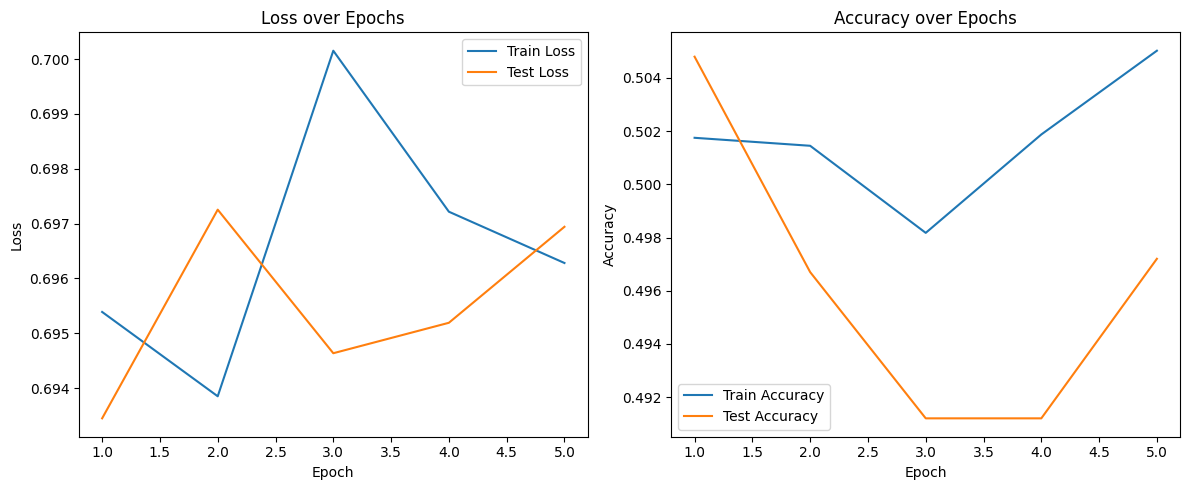

In [292]:
train(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=5)

## 11. Confusion Matrix

In [295]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 600x600 with 0 Axes>

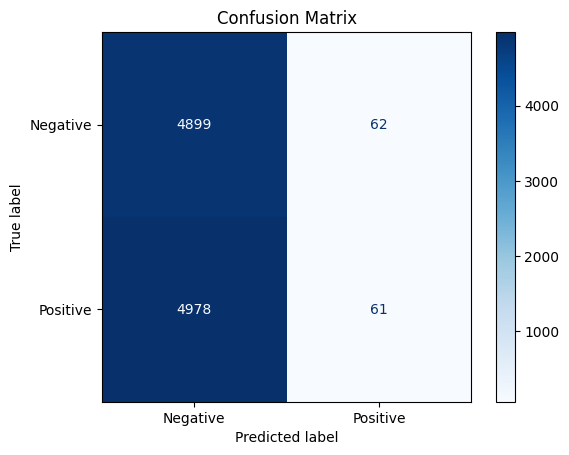

In [ ]:
def plot_confusion_matrix(model, data_loader, device, class_names=["Negative", "Positive"]):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            if outputs.shape[1] == 2:
                preds = torch.argmax(outputs, dim=1)
            else:
                preds = (torch.sigmoid(outputs) > 0.5).long().squeeze() 

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot
    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, test_loader, device, class_names=["Negative", "Positive"])

## 12. precision, recall, f1 score

In [297]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [ ]:
def evaluate_detailed_metrics(model, data_loader, device, class_names=["Negative", "Positive"]):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            if outputs.shape[1] == 2:  
                preds = torch.argmax(outputs, dim=1)
            else:  
                preds = (torch.sigmoid(outputs) > 0.5).long().squeeze()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds, average=None)
    return precision, recall, f1, support

precision, recall, f1, support = evaluate_detailed_metrics(model, test_loader, device)



 Classification Report:
              precision    recall  f1-score   support

    Negative     0.4960    0.9875    0.6603      4961
    Positive     0.4959    0.0121    0.0236      5039

    accuracy                         0.4960     10000
   macro avg     0.4960    0.4998    0.3420     10000
weighted avg     0.4960    0.4960    0.3395     10000



Epoch 1/5
  Train Loss: 0.6968, Accuracy: 0.5022
  Test  Loss: 0.7079, Accuracy: 0.5033
--------------------------------------------------
Epoch 2/5
  Train Loss: 0.6975, Accuracy: 0.4994
  Test  Loss: 0.6942, Accuracy: 0.5027
--------------------------------------------------
Epoch 3/5
  Train Loss: 0.6969, Accuracy: 0.5012
  Test  Loss: 0.6967, Accuracy: 0.4930
--------------------------------------------------
Epoch 4/5
  Train Loss: 0.6968, Accuracy: 0.5031
  Test  Loss: 0.6950, Accuracy: 0.4987
--------------------------------------------------
Epoch 5/5
  Train Loss: 0.6971, Accuracy: 0.5009
  Test  Loss: 0.6951, Accuracy: 0.4960
--------------------------------------------------


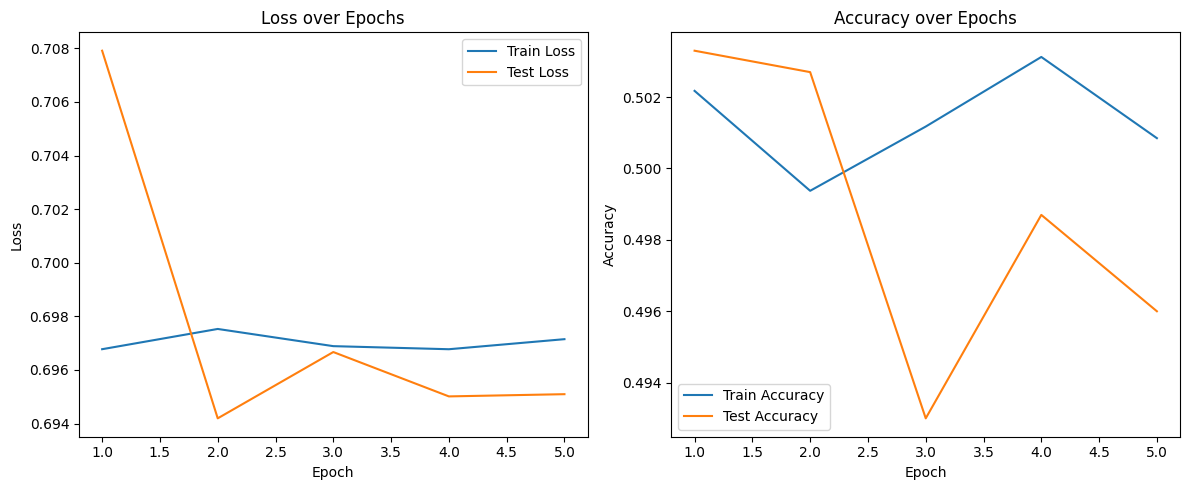

In [293]:
embedding_dim_increase = 128

model_increase_embedding_dimension = RNN(vocab_size, embedding_dim_increase, hidden_size, output_size).to(device)
train(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=5)